In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import random
import numpy as np
import os 
from torch_geometric.data import DataLoader

from Chromatin3D.Data_Tools.Data_Access import get_data_from_path, VanillaDataset, set_logits_data
from Chromatin3D.Data_Tools.Data_Plotting import plot_structure_in_sphere, plot_hic, plot_optimal_transport, plot_losses, plot_test_distance_matrix, plot_true_pred_structures, plot_hist_kabsch_distances, plot_grad_flow, plot_pred_conf
from Chromatin3D.Model.model import UniformLinear, train_uniform_linear, evaluate_uniform_linear, ConfLinear, train_conf_linear, evaluate_conf_linear
from Chromatin3D.Model.losses import compute_trussart_test_kabsch_loss, biological_loss_fct, kabsch_loss_fct
from Chromatin3D.Data_Tools.Data_Calculation import save_structure, import_trussart_data, kabsch_superimposition_numpy, kabsch_distance_numpy, make_gif, scale_logits, mse_unscaled_scaled
from Chromatin3D.Model.lddt_tools import lddt, get_confidence_metrics
from Chromatin3D.Model.calibration_nn import ModelWithTemperature, isotonic_calibration, beta_calibration
from scipy.spatial import distance_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


ZERO_INIT = True
EXPONENT = 1
NUM_BINS_LOGITS = 100
NB_EPOCHS = 100
SEED = 0
BATCH_SIZE = 10
NB_BINS = 202
EMBEDDING_SIZE = 3
LAMBDA_BIO = 0
LAMBDA_KABSCH = 0
LAMBDA_LDDT = 0.1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)
DATA_DIR = os.environ.get('DATA_DIR')
DATA_PATH=f'{DATA_DIR}/biological_trussart_special_values'
TRAIN_DATASET_SIZE = 800
TEST_DATASET_SIZE = 200



In [3]:
train_transfer_learning_hics, test_transfer_learning_hics, train_transfer_learning_structures, test_transfer_learning_structures, train_transfer_learning_distances, test_transfer_learning_distances = get_data_from_path(DATA_PATH)


In [4]:
train_dataset = VanillaDataset(root = '', is_training = True, dataset_size = TRAIN_DATASET_SIZE, hics = train_transfer_learning_hics, structures = train_transfer_learning_structures, distances = train_transfer_learning_distances)
train_dataset = train_dataset.shuffle()
train_size = len(train_dataset)
print(train_size)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)

800


In [5]:
test_dataset = VanillaDataset(root = '', is_training = False, dataset_size = TEST_DATASET_SIZE, hics = test_transfer_learning_hics, structures = test_transfer_learning_structures, distances = test_transfer_learning_distances)
test_dataset = test_dataset.shuffle()

test_train_idx, test_test_idx = train_test_split(list(range(len(test_dataset))), test_size=0.1)
test_train_calib = test_dataset.index_select(test_train_idx)
test_test_calib= test_dataset.index_select(test_test_idx)

test_size = len(test_dataset)

test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)
test_train_calib_loader = DataLoader(test_train_calib, batch_size=BATCH_SIZE)
test_test_calib_loader = DataLoader(test_test_calib, batch_size=BATCH_SIZE)

In [6]:
trussart_structures = []
file_list = os.listdir(f"{DATA_DIR}/trussart/structure_matrices/")
file_list = filter(lambda f: f.endswith('.xyz'), file_list)

for file_name in file_list:
    current_trussart_structure = np.loadtxt(f"{DATA_DIR}/trussart/structure_matrices/" + file_name, dtype='f', delimiter='\t')
    current_trussart_structure = current_trussart_structure[:,1:]
    trussart_structures.append(current_trussart_structure)

In [7]:
def compute_hic_matrix(distance_matrix, alpha):
        
    distance_matrix = np.where(distance_matrix == 0, np.inf, distance_matrix)
    
    hic_matrix = np.zeros((len(distance_matrix), len(distance_matrix)))
    hic_matrix = np.where(distance_matrix == np.inf, hic_matrix, np.power(distance_matrix, -alpha))
    
    return hic_matrix

In [8]:
precomputed_distances = distance_matrix(trussart_structures[0], trussart_structures[0])
for structure in trussart_structures[1:]:
    precomputed_distances += distance_matrix(structure, structure)
precomputed_distances /= len(trussart_structures)

trussart_hic = compute_hic_matrix(precomputed_distances, EXPONENT) 
# Min Max scaling
scaler = MinMaxScaler()
trussart_hic = scaler.fit_transform(trussart_hic)

In [9]:
distance_loss_fct = torch.nn.MSELoss()

In [10]:
device = torch.device('cpu')
model = ConfLinear(NB_BINS, EMBEDDING_SIZE, BATCH_SIZE, NUM_BINS_LOGITS, ZERO_INIT).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [11]:
train_biological_losses_all_epochs = []
train_kabsch_losses_all_epochs = []
train_distance_losses_all_epochs = []
train_lddt_losses_all_epochs = []

test_biological_losses_all_epochs = []
test_kabsch_losses_all_epochs = []
test_distance_losses_all_epochs = []
test_lddt_losses_all_epochs = []

losses = []

trussart_test_kabsch_losses_all_epochs = []

for epoch in range(1, NB_EPOCHS+1):
    loss = train_conf_linear(model, train_loader, train_dataset, optimizer, device, BATCH_SIZE,  NB_BINS, EMBEDDING_SIZE, LAMBDA_BIO, LAMBDA_KABSCH, distance_loss_fct, LAMBDA_LDDT, NUM_BINS_LOGITS)
    losses.append(loss)
    
    ### Training
    train_mean_biological_loss, train_mean_kabsch_loss, train_mean_distance_loss, train_true_hics, \
        train_pred_structures, train_true_structures, train_pred_distances, \
            train_true_distances, train_mean_lddt_loss = evaluate_conf_linear(train_loader, model, device, BATCH_SIZE, NB_BINS, EMBEDDING_SIZE, distance_loss_fct, NUM_BINS_LOGITS) 
    
    # Store results
    train_biological_losses_all_epochs.append(train_mean_biological_loss)
    train_kabsch_losses_all_epochs.append(train_mean_kabsch_loss)    
    train_distance_losses_all_epochs.append(train_mean_distance_loss)
    train_lddt_losses_all_epochs.append(train_mean_lddt_loss)

    ### Testing
    test_mean_biological_loss, test_mean_kabsch_loss, test_mean_distance_loss, test_true_hics, \
        test_pred_structures, test_true_structures, test_pred_distances, \
            test_true_distances, test_mean_lddt_loss = evaluate_conf_linear(test_loader, model, device, BATCH_SIZE, NB_BINS, EMBEDDING_SIZE, distance_loss_fct, NUM_BINS_LOGITS) 
    
    ### Trussart test
    trussart_test_kabsch_loss = compute_trussart_test_kabsch_loss(trussart_hic, trussart_structures, model, NB_BINS, BATCH_SIZE, EMBEDDING_SIZE, True)
    save_structure(model, epoch, trussart_structures, trussart_hic, NB_BINS, BATCH_SIZE, EMBEDDING_SIZE, True)
    # Store results
    test_biological_losses_all_epochs.append(test_mean_biological_loss)
    test_kabsch_losses_all_epochs.append(test_mean_kabsch_loss)    
    test_distance_losses_all_epochs.append(test_mean_distance_loss)
    test_lddt_losses_all_epochs.append(test_mean_lddt_loss)

    
    trussart_test_kabsch_losses_all_epochs.append(trussart_test_kabsch_loss)
    
    print('E: {:03d}, Tr B: {:.4f}, Tr K: {:.4f}, Tr D: {:.4f}, Te B: {:.4f}, Te K: {:.4f}, Te D: {:.4f}, Tr LD: {:.4f}, Te LD: {:.4f}, Trus: {:.4f}'.format(\
        epoch, train_mean_biological_loss, train_mean_kabsch_loss, train_mean_distance_loss, \
            test_mean_biological_loss, test_mean_kabsch_loss, test_mean_distance_loss,train_mean_lddt_loss, test_mean_lddt_loss, trussart_test_kabsch_loss))

E: 001, Tr B: 0.0607, Tr K: 0.1077, Tr D: 0.0379, Te B: 0.0560, Te K: 0.1086, Te D: 0.0368, Tr LD: 0.4509, Te LD: 0.4510, Trus: 0.0745
E: 002, Tr B: 0.0586, Tr K: 0.0998, Tr D: 0.0299, Te B: 0.0547, Te K: 0.1009, Te D: 0.0298, Tr LD: 0.4359, Te LD: 0.4359, Trus: 0.0524
E: 003, Tr B: 0.0586, Tr K: 0.0842, Tr D: 0.0206, Te B: 0.0535, Te K: 0.0847, Te D: 0.0203, Tr LD: 0.4215, Te LD: 0.4218, Trus: 0.0365
E: 004, Tr B: 0.0569, Tr K: 0.0798, Tr D: 0.0174, Te B: 0.0530, Te K: 0.0808, Te D: 0.0174, Tr LD: 0.4084, Te LD: 0.4089, Trus: 0.0304
E: 005, Tr B: 0.0568, Tr K: 0.0775, Tr D: 0.0153, Te B: 0.0528, Te K: 0.0786, Te D: 0.0153, Tr LD: 0.3960, Te LD: 0.3970, Trus: 0.0325
E: 006, Tr B: 0.0564, Tr K: 0.0768, Tr D: 0.0148, Te B: 0.0524, Te K: 0.0779, Te D: 0.0146, Tr LD: 0.3842, Te LD: 0.3845, Trus: 0.0285
E: 007, Tr B: 0.0566, Tr K: 0.0771, Tr D: 0.0145, Te B: 0.0524, Te K: 0.0782, Te D: 0.0145, Tr LD: 0.3725, Te LD: 0.3737, Trus: 0.0304
E: 008, Tr B: 0.0564, Tr K: 0.0758, Tr D: 0.0137, Te B:

In [12]:
print(np.where(trussart_test_kabsch_losses_all_epochs == min(trussart_test_kabsch_losses_all_epochs)))
print(min(trussart_test_kabsch_losses_all_epochs))

(array([61]),)
0.023309953599428678


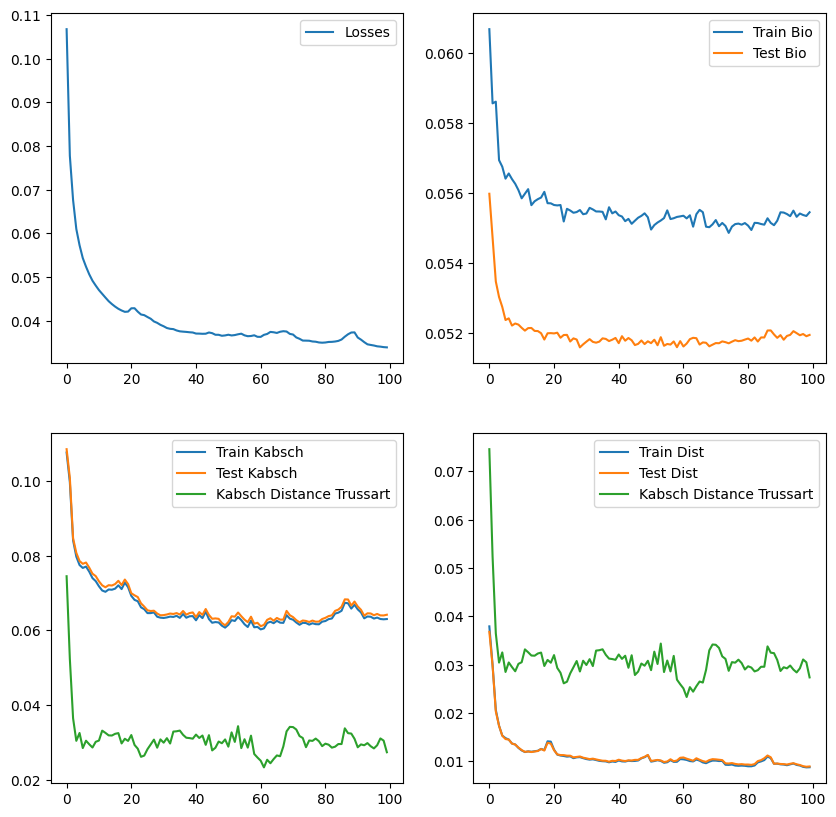

In [13]:
plot_losses(losses, train_biological_losses_all_epochs, test_biological_losses_all_epochs, train_kabsch_losses_all_epochs, test_kabsch_losses_all_epochs, trussart_test_kabsch_losses_all_epochs, train_distance_losses_all_epochs, test_distance_losses_all_epochs)


tensor(0.0001)
linear_encoder_layer_1.weight
tensor(0.0002)
linear_encoder_layer_2.weight
tensor(0.0011)
linear_encoder_layer_3.weight
tensor(3.4706e-06)
linear_bin_layer.weight


/Users/hva/Documents/3D-Chromatin/Chromatin3D/Data_Tools/Data_Plotting.py:107: UserWarning:

Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.



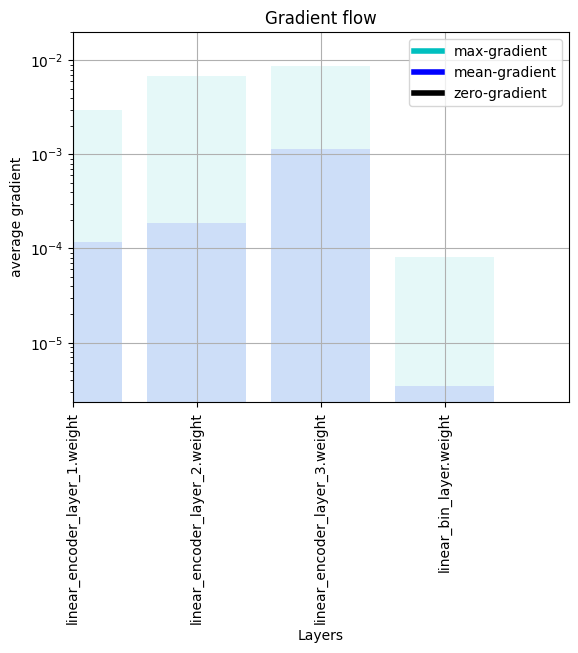

In [14]:
plot_grad_flow(model.named_parameters())

In [15]:
GRAPH_TESTED = 0

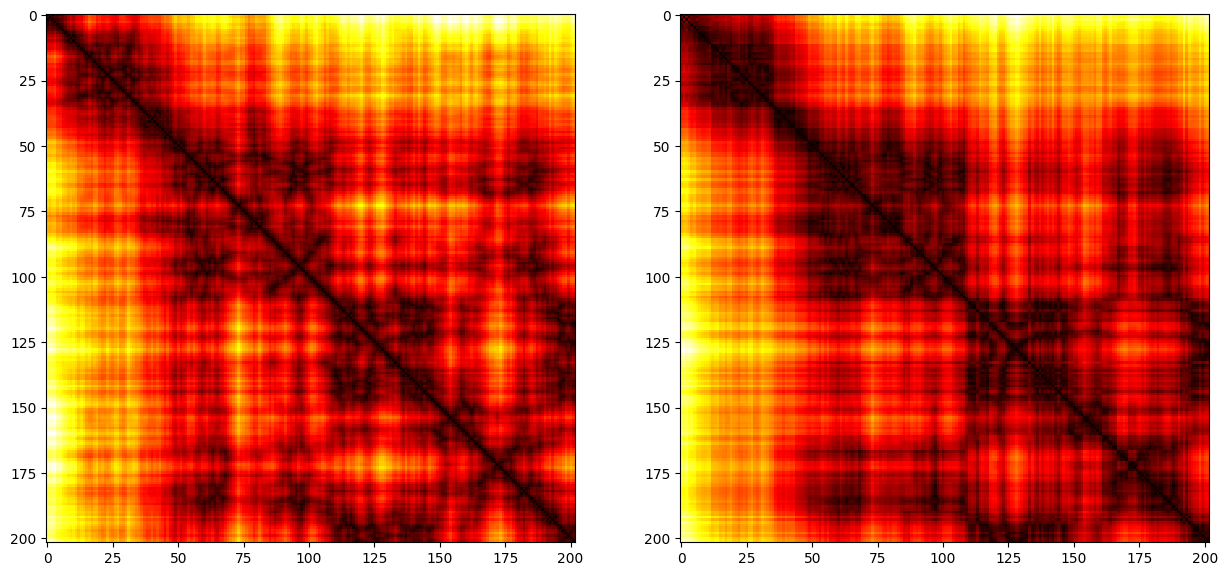

In [16]:
ground_truth_matrix = test_true_distances[GRAPH_TESTED*NB_BINS:GRAPH_TESTED*NB_BINS+NB_BINS, :]
reconstruction_matrix = test_pred_distances[GRAPH_TESTED*NB_BINS:GRAPH_TESTED*NB_BINS+NB_BINS, :]
plot_test_distance_matrix(ground_truth_matrix, reconstruction_matrix)

In [17]:
test_true_structure = test_true_structures[GRAPH_TESTED]
test_pred_structure = test_pred_structures[GRAPH_TESTED]

test_pred_structure_superposed, test_true_structure_superposed = \
        kabsch_superimposition_numpy(test_pred_structure, test_true_structure, EMBEDDING_SIZE)

x_pred = test_pred_structure_superposed[:, 0]  
y_pred = test_pred_structure_superposed[:, 1]
z_pred = test_pred_structure_superposed[:, 2]

x_true = test_true_structure_superposed[:, 0]  
y_true = test_true_structure_superposed[:, 1]
z_true = test_true_structure_superposed[:, 2]

colorscale1 = np.asarray(range(len(x_true)))
colorscale2 = np.asarray(range(len(x_pred)))
color1 = 'Viridis'
color2 = 'Viridis'

plot_true_pred_structures(x_pred, y_pred, z_pred, x_true, y_true, z_true, colorscale1, colorscale2, color1, color2)

# Shape comparison
print('Kabsch distance is ' + str(kabsch_distance_numpy(test_pred_structure, test_true_structure, EMBEDDING_SIZE)))



Kabsch distance is 0.08407879052457376


<Figure size 50000x50000 with 0 Axes>

In [18]:
test_true_structure = test_true_structures[GRAPH_TESTED]
test_pred_structure = test_pred_structures[GRAPH_TESTED]

test_pred_structure_superposed, test_true_structure_superposed = \
        kabsch_superimposition_numpy(test_pred_structure, test_true_structure, EMBEDDING_SIZE)

x_pred = test_pred_structure_superposed[:, 0]  
y_pred = test_pred_structure_superposed[:, 1]
z_pred = test_pred_structure_superposed[:, 2]

x_true = test_true_structure_superposed[:, 0]  
y_true = test_true_structure_superposed[:, 1]
z_true = test_true_structure_superposed[:, 2]
pred_structure_unit_ball, true_structure_unit_ball = \
            kabsch_superimposition_numpy(test_pred_structure, test_true_structure, EMBEDDING_SIZE)
d = np.negative(np.log(np.mean(np.divide(np.abs(pred_structure_unit_ball - true_structure_unit_ball),np.abs(true_structure_unit_ball)), axis=1)))

colorscale1 = np.asarray(range(len(x_true)))
colorscale2 = d
color1 = 'Viridis'
color2 = 'rainbow'
plot_true_pred_structures(x_pred, y_pred, z_pred, x_true, y_true, z_true, colorscale1, colorscale2, color1, color2)

# Shape comparison
print('Kabsch distance is ' + str(kabsch_distance_numpy(test_pred_structure, test_true_structure, EMBEDDING_SIZE)))



Kabsch distance is 0.08407879052457376


<Figure size 50000x50000 with 0 Axes>

In [19]:
random_structure = np.random.random((202,3))
test_true_structure = test_true_structures[GRAPH_TESTED]
print(lddt(torch.from_numpy(test_pred_structure_superposed).unsqueeze(0), torch.from_numpy(test_true_structure_superposed).unsqueeze(0)))

random_structure_superposed, true_to_random_structure_superposed = \
        kabsch_superimposition_numpy(random_structure, test_true_structure, EMBEDDING_SIZE)

print(lddt(torch.from_numpy(random_structure_superposed).unsqueeze(0), torch.from_numpy(true_to_random_structure_superposed).unsqueeze(0)))
#print(test_true_structures[GRAPH_TESTED].shape)


tensor([0.8891], dtype=torch.float64)
tensor([0.5074], dtype=torch.float64)


In [20]:
make_gif("", "gifs/trussart_linear.gif")

In [21]:
# Trussart perfect structure
trussart_true_structure = np.mean(trussart_structures, axis=0)

# Trussart predicted structure
torch_trussart_hic = torch.FloatTensor(trussart_hic)
torch_trussart_hic = torch.reshape(torch_trussart_hic, (1, NB_BINS, NB_BINS))
torch_trussart_hic = torch.repeat_interleave(torch_trussart_hic, BATCH_SIZE, 0)

trussart_pred_structure, trussart_pred_distance, trussart_pred_logits = model(torch_trussart_hic)
trussart_pred_structure = trussart_pred_structure.detach().numpy()[0]

# Superpose structure using Kabsch algorithm
trussart_pred_structure_superposed, trussart_true_structure_superposed = \
        kabsch_superimposition_numpy(trussart_pred_structure, trussart_true_structure, EMBEDDING_SIZE)

# Plot and compare the two structures
x_pred = trussart_pred_structure_superposed[:, 0]  
y_pred = trussart_pred_structure_superposed[:, 1]
z_pred = trussart_pred_structure_superposed[:, 2]

x_true = trussart_true_structure_superposed[:, 0]  
y_true = trussart_true_structure_superposed[:, 1]
z_true = trussart_true_structure_superposed[:, 2]

colorscale1 = np.asarray(range(len(x_true)))
colorscale2 = np.asarray(range(len(x_pred)))
color1 = 'Viridis'
color2 = 'Viridis'

plot_true_pred_structures(x_pred, y_pred, z_pred, x_true, y_true, z_true, colorscale1, colorscale2, color1, color2)

# Shape comparison
print('Kabsch distance is ' + str(kabsch_distance_numpy(trussart_pred_structure, trussart_true_structure, EMBEDDING_SIZE)))

Kabsch distance is 0.02629470898870716


<Figure size 50000x50000 with 0 Axes>

In [22]:
confidence_metrics, pLLDTs = get_confidence_metrics(trussart_pred_logits.detach().numpy()[0])
print(confidence_metrics)

value = lddt(torch.from_numpy(trussart_pred_structure_superposed).unsqueeze(0),torch.from_numpy(trussart_true_structure_superposed).unsqueeze(0), per_residue=True)
print(torch.mean(value))

#print(pLLDTs)
#print(value)

88.76820159107015
tensor(0.8873, dtype=torch.float64)


In [23]:
color = 'rainbow'
plot_pred_conf(trussart_pred_structure_superposed, pLLDTs, color)

In [24]:
####Max error to confidence interval
dmat_true = torch.sqrt(1e-10 + torch.sum(
    (torch.from_numpy(trussart_true_structure_superposed).unsqueeze(0)[:, :, None] - torch.from_numpy(trussart_true_structure_superposed).unsqueeze(0)[:, None, :])**2, axis=-1))
dmat_predicted = torch.sqrt(1e-10 + torch.sum(
    (torch.from_numpy(trussart_pred_structure_superposed).unsqueeze(0)[:, :, None] -
    torch.from_numpy(trussart_pred_structure_superposed).unsqueeze(0)[:, None, :])**2, axis=-1))

dists_to_score = (
    (dmat_true).type(torch.FloatTensor) *(1. - torch.eye(dmat_true.shape[1]))  
)

dist_l1 = torch.abs(dmat_true - dmat_predicted)
relative_error = torch.mean(torch.div(dist_l1, torch.abs(dmat_true))[0], dim=0)

print(relative_error.shape)
print(torch.topk(torch.mean(dist_l1[0],dim=0), k=10))
print(torch.topk(relative_error, k=10, largest=True))
print(np.argpartition(pLLDTs, 10)[:10])
print(torch.topk(value[0], k=10, largest=False))

torch.Size([202])
torch.return_types.topk(
values=tensor([0.1570, 0.1527, 0.1521, 0.1501, 0.1485, 0.1466, 0.1458, 0.1448, 0.1431,
        0.1421], dtype=torch.float64),
indices=tensor([ 56, 110,  59, 106,  63,  50,  17,  70,  54,  69]))
torch.return_types.topk(
values=tensor([0.2180, 0.2161, 0.2156, 0.2152, 0.2068, 0.2038, 0.1996, 0.1965, 0.1918,
        0.1915], dtype=torch.float64),
indices=tensor([ 13,  15,  17,  16,  70, 106, 110, 132,  71,  69]))
[67 65 70 69 68 72 66 62 63 73]
torch.return_types.topk(
values=tensor([0.7996, 0.8067, 0.8072, 0.8081, 0.8154, 0.8182, 0.8257, 0.8268, 0.8307,
        0.8310], dtype=torch.float64),
indices=tensor([ 17,  16,  13,  15,  70,  18,  69,  71,  63, 106]))


In [25]:
orig_model = model
valid_loader = test_train_calib_loader
logits_test_temp, labels_test_temp = set_logits_data(test_test_calib_loader, device, model, BATCH_SIZE, NB_BINS, EMBEDDING_SIZE, NUM_BINS_LOGITS)
scaled_model = ModelWithTemperature(orig_model, device, BATCH_SIZE, NB_BINS, EMBEDDING_SIZE, NUM_BINS_LOGITS)
scaled_model.set_temperature(valid_loader)
m = torch.nn.LogSoftmax(dim=1)
nll_criterion = torch.nn.BCEWithLogitsLoss()
print(nll_criterion(m(logits_test_temp), labels_test_temp).item())
logits_test_temps_scaled = scaled_model.temperature_scale(logits_test_temp)

print(nll_criterion(m(logits_test_temps_scaled), labels_test_temp).item())

Before temperature - NLL: 0.036
tensor(0.7394, grad_fn=<MulBackward0>)
tensor(0.7389, grad_fn=<MulBackward0>)
tensor(0.7383, grad_fn=<MulBackward0>)
tensor(0.7377, grad_fn=<MulBackward0>)
tensor(0.7372, grad_fn=<MulBackward0>)
tensor(0.7367, grad_fn=<MulBackward0>)
tensor(0.7361, grad_fn=<MulBackward0>)
tensor(0.7356, grad_fn=<MulBackward0>)
tensor(0.7351, grad_fn=<MulBackward0>)
tensor(0.7345, grad_fn=<MulBackward0>)
tensor(0.7340, grad_fn=<MulBackward0>)
tensor(0.7335, grad_fn=<MulBackward0>)
tensor(0.7330, grad_fn=<MulBackward0>)
tensor(0.7326, grad_fn=<MulBackward0>)
tensor(0.7321, grad_fn=<MulBackward0>)
tensor(0.7316, grad_fn=<MulBackward0>)
tensor(0.7312, grad_fn=<MulBackward0>)
tensor(0.7307, grad_fn=<MulBackward0>)
tensor(0.7303, grad_fn=<MulBackward0>)
tensor(0.7298, grad_fn=<MulBackward0>)
tensor(0.7294, grad_fn=<MulBackward0>)
tensor(0.7290, grad_fn=<MulBackward0>)
tensor(0.7286, grad_fn=<MulBackward0>)
tensor(0.7282, grad_fn=<MulBackward0>)
tensor(0.7278, grad_fn=<MulBackw

In [26]:
confidence_metric_scaled, plddt_scaled = scale_logits(trussart_pred_logits, scaled_model, BATCH_SIZE, NB_BINS)
print(confidence_metric_scaled)
print(plddt_scaled)

88.90426786402055
[86.81059956 87.29731487 88.07024151 88.6615639  90.02857242 90.61829364
 91.12906169 91.34258482 91.24978899 91.00063145 90.49853301 89.85296213
 89.4480464  88.7245449  88.31309122 88.21048339 88.7331663  88.8847235
 89.03689047 89.46457519 90.25627172 90.37342564 90.82168566 91.0737568
 91.56926606 91.8033634  92.08292489 91.88396951 91.91301902 91.73271924
 91.6561525  91.67929007 91.46445503 91.52706153 91.44218224 91.48509138
 91.92136051 91.82379824 91.74502781 91.73204094 91.7016386  91.28366113
 91.15127846 90.64562575 90.15071738 89.54801216 89.23747793 88.30405993
 88.35369998 88.05061868 87.16453122 86.93878547 86.98960407 87.54266698
 87.50967626 87.77587765 87.45840463 87.87947332 87.33871438 86.99105609
 86.80262618 86.80262618 86.80262618 86.80262618 86.80262618 86.80262618
 86.80262618 86.80262618 86.80262618 86.80262618 86.80262618 86.80262618
 86.80262618 86.80262618 86.80262618 86.84501789 87.85123481 87.65740838
 86.91242102 86.80262618 86.8026261

In [27]:
mse_unscalled, mse_scalled = mse_unscaled_scaled(value, pLLDTs, plddt_scaled)
print(mse_unscalled)
print(mse_scalled)

8.724723069496806
8.677985591199405


In [28]:
valid_loader = test_train_calib_loader
logits_test_temp, labels_test_temp = set_logits_data(test_train_calib_loader, device, model, BATCH_SIZE, NB_BINS, EMBEDDING_SIZE, NUM_BINS_LOGITS)

In [29]:
confidence_metric_iso, pLDDT_iso = isotonic_calibration(logits_test_temp, labels_test_temp, trussart_pred_logits)
print(confidence_metric_iso)
print(pLDDT_iso)

2.639982406095047
3.2795623763821964
88.54661250166428
[86.09927455 86.50404399 87.06054392 87.8023311  89.56517498 90.24246565
 90.73151093 91.13616725 90.80611172 90.52402216 89.92676    89.18595463
 88.69251999 87.91877484 87.40662621 87.26461915 88.00782078 88.06895289
 88.29403687 88.76495931 89.76062022 89.81485398 90.41828409 90.62807259
 91.65311921 91.95708604 92.27423191 92.06647961 92.10118611 91.85516318
 91.74323723 91.8255367  91.3479889  91.54160153 91.30320824 91.2898923
 92.45709237 92.35167356 92.28329684 92.25158346 92.11435745 91.18052635
 90.77726865 90.04027451 89.49881701 88.80008288 88.34897186 87.38043621
 87.46880955 87.10941186 86.43135528 86.26937383 86.30145006 86.76009601
 86.74843848 86.9281797  86.64288308 86.98140838 86.49221825 86.30185764
 87.54180187 87.54180187 87.54180187 87.54180187 87.54180187 87.54180187
 87.54180187 87.54180187 87.54180187 87.54180187 87.54180187 87.54180187
 87.54180187 87.54180187 87.54180187 86.14081891 86.95665186 86.831220

In [30]:
mse_unscalled, mse_scalled = mse_unscaled_scaled(value, pLLDTs, pLDDT_iso)
print(mse_unscalled)
print(mse_scalled)

8.724723069496806
8.784060066680096


In [31]:
valid_loader = test_train_calib_loader
logits_test_temp, labels_test_temp = set_logits_data(test_train_calib_loader, device, model, BATCH_SIZE, NB_BINS, EMBEDDING_SIZE, NUM_BINS_LOGITS)

In [32]:
confidence_metric_beta, pLDDT_beta = beta_calibration(logits_test_temp, labels_test_temp, trussart_pred_logits)
print(confidence_metric_beta)
print(pLDDT_beta)

2.639982406095047
2.624145609842013
88.35116631498718
[86.1351695  86.59643364 87.33940246 87.92750035 89.38391339 90.08799688
 90.70709715 90.98476644 90.85187432 90.54646076 89.91623313 89.16145632
 88.71791761 88.02176681 87.57024205 87.55810112 88.11665058 88.25025356
 88.38718123 88.78923855 89.68927315 89.77815499 90.31190925 90.62876157
 91.26800176 91.59084849 91.92748666 91.68609583 91.72626938 91.48275879
 91.38248285 91.41414523 91.13306969 91.22219989 91.12298058 91.19917151
 91.77582169 91.81525017 91.69927772 91.68025056 91.63569476 91.03336675
 90.84743104 90.16276304 89.53556257 88.82831308 88.48601905 87.52891175
 87.57756279 87.28365407 86.45680875 86.25115397 86.29730591 86.80497434
 86.77437061 87.0228585  86.72690208 87.12063115 86.6164846  86.29863879
 86.12761214 86.12761214 86.12761214 86.12761214 86.12761214 86.12761214
 86.12761214 86.12761214 86.12761214 86.12761214 86.12761214 86.12761214
 86.12761214 86.12761214 86.12761214 86.16603223 87.09390016 86.911840

In [33]:
mse_unscalled, mse_scalled = mse_unscaled_scaled(value, pLLDTs, pLDDT_beta)
print(mse_unscalled)
print(mse_scalled)

8.724723069496806
8.850513113767418


In [34]:
color = 'rainbow'
plot_pred_conf(trussart_pred_structure_superposed, plddt_scaled, color)

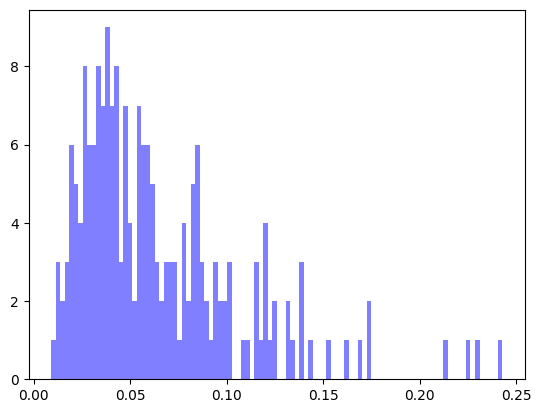

mean: 0.06422309253649768
median: 0.05371385081679371
variance: 0.001814960453165598


In [35]:
plot_hist_kabsch_distances(test_size, test_true_structures, test_pred_structures, EMBEDDING_SIZE)

In [36]:
RESULTS_ROOT = '../../saved_results/synthetic_biological_trussart_testing/linear/'
LAMBDA_CONFIGURATION = str(LAMBDA_BIO) + '_' + str(LAMBDA_KABSCH)

In [37]:
np.savetxt(RESULTS_ROOT + 'synthetic_biological_trussart_testing_linear_losses_' + LAMBDA_CONFIGURATION + '.txt', losses)

np.savetxt(RESULTS_ROOT + 'synthetic_biological_trussart_testing_linear_train_biological_losses_all_epochs_' +
               LAMBDA_CONFIGURATION + '.txt', train_biological_losses_all_epochs)
np.savetxt(RESULTS_ROOT + 'synthetic_biological_trussart_testing_linear_test_biological_losses_all_epochs_' +
               LAMBDA_CONFIGURATION + '.txt', test_biological_losses_all_epochs)

np.savetxt(RESULTS_ROOT + 'synthetic_biological_trussart_testing_linear_train_kabsch_losses_all_epochs_' + 
           LAMBDA_CONFIGURATION + '.txt', train_kabsch_losses_all_epochs)
np.savetxt(RESULTS_ROOT + 'synthetic_biological_trussart_testing_linear_test_kabsch_losses_all_epochs_' + 
           LAMBDA_CONFIGURATION + '.txt', test_kabsch_losses_all_epochs)

np.savetxt(RESULTS_ROOT + 'synthetic_biological_trussart_testing_linear_train_distance_losses_all_epochs_' +
           LAMBDA_CONFIGURATION + '.txt', train_distance_losses_all_epochs)
np.savetxt(RESULTS_ROOT + 'synthetic_biological_trussart_testing_linear_test_distance_losses_all_epochs_' + 
           LAMBDA_CONFIGURATION + '.txt', test_distance_losses_all_epochs)

np.savetxt(RESULTS_ROOT + 'synthetic_biological_trussart_testing_linear_trussart_test_kabsch_losses_all_epochs_' +
               LAMBDA_CONFIGURATION + '.txt', trussart_test_kabsch_losses_all_epochs)

In [38]:
torch.save(model, 
           '../../saved_models/synthetic_biological_trussart_testing/linear/synthetic_biological_trussart_uniform_linear_model_' + 
           LAMBDA_CONFIGURATION + '.pt')